In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import pickle
import joblib
import time


In [2]:
def load_cls(fname):
    return np.array(pickle.load(open(fname,"rb")))

In [3]:
path = "../data/"
trainSamples = 500
n_iter = 100
n_trainSamples = [100,500,1000,10000,20000,50000,75000]

In [4]:
X_train = load_cls(path+"X_train_tokens.p")[:trainSamples]
X_val_cls = load_cls(path+"X_val_tokens.p")

In [5]:
print(len(X_train))

500


In [6]:
y_train = load_cls(path+"y_train.p")[:trainSamples]
y_val = load_cls(path+"y_val.p")

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

def my_preprocessor(doc):
    return doc

# tokenize the doc and lemmatize its tokens
def my_tokenizer(doc):
    return doc

custom_vec = CountVectorizer(preprocessor=my_preprocessor, tokenizer=my_tokenizer)
cwm = custom_vec.fit_transform(X_train)
tokens = custom_vec.get_feature_names()

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer,TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.preprocessing import MaxAbsScaler,StandardScaler

In [9]:
feature_pipeline = Pipeline([
('vect',  CountVectorizer(min_df=.0025, max_df=0.25, ngram_range=(1,3),preprocessor=my_preprocessor, tokenizer=my_tokenizer)),
('tfidf', TfidfTransformer()),
])

In [10]:
X_train_f = feature_pipeline.fit_transform(X_train)
X_val_f =feature_pipeline.transform(X_val_cls)

In [46]:
scaling = StandardScaler(with_mean=False).fit(X_train_f)
X_train_z = scaling.transform(X_train_f)
X_val_f = scaling.transform(X_val_f)

In [42]:
from sklearn.model_selection import GridSearchCV
parameters = {
     'C': [0.001, 0.01, 0.1, 1,10],
     'gamma': [0.001, 0.01, 0.1, 1],
    'degree': [2,3,4,5]
 }

In [43]:
gs_clf = GridSearchCV(svm.SVC(verbose=True,probability=True,cache_size=7000,max_iter=n_iter,gamma='auto',kernel='poly'), 
                      parameters, cv=5, iid=True, n_jobs=-1, verbose=4)

In [47]:
model = gs_clf.fit(X_train_z, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.1min finished


[LibSVM]

/home/kuntal/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


In [48]:
model.best_score_

0.51

In [49]:
print(model.best_params_)
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, model.best_params_[param_name]))

{'C': 0.001, 'degree': 2, 'gamma': 0.001}
C: 0.001
degree: 2
gamma: 0.001


In [16]:
pickle.dump(model,open("SVM_Poly_"+str(trainSamples)+"_"+str(n_iter)+".pkl",'wb'))

In [17]:
X_test = load_cls(path+"X_test_tokens.p")
y_test = load_cls(path+"y_test.p")

In [18]:
from scipy.stats import rankdata

def mrrs(out, labels):
#     print(out,labels)
    outputs = np.argmax(out,axis=1)
    mrr = 0.0 
    for label,ranks in zip(labels,out):
        ranks = rankdata(ranks*-1)
        rank = ranks[label]
#         print(rank,ranks)
        mrr+=1/rank
    return mrr/len(labels)

def mrrwrapper(qid2c,qid2indexmap,preds_prob):
    labels = []
    out = []
    for qid in qid2c.keys():
        scores = []
        for ix in qid2indexmap[qid]:
            if len(scores) < 6:
                scores.append(preds_prob[ix][1])
        if len(scores) < 6:
            continue
        out.append(scores)
        labels.append(int(qid2c[qid]))
    return mrrs(np.array(out),labels)

def load_ranking(fname):
    return pickle.load(open(path+"ranking_"+fname+".p","rb"))

In [19]:
from sklearn.metrics import accuracy_score

In [20]:
valAccuracy = []
testAccuracy = []
mrrScore = []

# For each of training sample sizes
for eachTrain in n_trainSamples:
    
    # Model with best values from grid search
    bestModel = svm.SVC(verbose=True,
                        probability=True,
                        cache_size=7000,
                        max_iter=n_iter,
                        gamma=model.best_params_['gamma'],
                        degree=model.best_params_['degree'],
                        kernel='poly',
                        C=model.best_params_['C'])

    print("SampleSize:",eachTrain)
    
    stime=time.time()
    X_train_f = feature_pipeline.fit_transform(X_train[:eachTrain])
    bestModel.fit(X_train_f,y_train[:eachTrain])   
    print("Train Time:%.2f sec"%(time.time()-stime))
    
    stime=time.time()
    X_val_f = feature_pipeline.transform(X_val_cls)
    preds_val = bestModel.predict(X_val_f)
    accuracy = round(accuracy_score(y_val, preds_val),4)
    valAccuracy.append(accuracy)
    print("Validation Accuracy: %.2f%%" % (accuracy * 100.0))
    print("Validation Time:%.2f sec"%(time.time()-stime))

    stime=time.time()
    X_test_f = feature_pipeline.transform(X_test)
    preds_test = bestModel.predict(X_test_f)
    accuracy = round(accuracy_score(y_test, preds_test),4)
    testAccuracy.append(accuracy)
    print("Test Accuracy: %.2f%%" % (accuracy * 100.0))
    print("Test Time:%.2f sec"%(time.time()-stime))
    
    stime=time.time()
    preds_test_probs = bestModel.predict_proba(X_test_f)
    qid2c,qid2indexmap = load_ranking("test")
    mrr = round(mrrwrapper(qid2c,qid2indexmap,preds_test_probs),4)
    mrrScore.append(mrr)
    print("MRR:",mrr)
    print("MRR Time:%.2f sec"%(time.time()-stime))
    
    #input()
print (valAccuracy)
print (testAccuracy)
print (mrrScore)

SampleSize: 100
[LibSVM]Train Time:0.19 sec
Validation Accuracy: 50.00%
Validation Time:4.30 sec
Test Accuracy: 50.00%
Test Time:4.20 sec
MRR: 0.2857
MRR Time:1.09 sec
SampleSize: 500
[LibSVM]Train Time:1.02 sec
Validation Accuracy: 50.33%
Validation Time:5.37 sec
Test Accuracy: 50.10%
Test Time:5.39 sec
MRR: 0.2857
MRR Time:2.19 sec
SampleSize: 1000
[LibSVM]Train Time:1.02 sec
Validation Accuracy: 50.33%
Validation Time:5.55 sec
Test Accuracy: 50.10%
Test Time:5.65 sec
MRR: 0.2857
MRR Time:2.19 sec
SampleSize: 10000
[LibSVM]Train Time:1.02 sec
Validation Accuracy: 50.33%
Validation Time:5.42 sec
Test Accuracy: 50.10%
Test Time:5.43 sec
MRR: 0.2857
MRR Time:2.20 sec
SampleSize: 20000
[LibSVM]Train Time:1.00 sec
Validation Accuracy: 50.33%
Validation Time:5.43 sec
Test Accuracy: 50.10%
Test Time:5.45 sec
MRR: 0.2857
MRR Time:2.20 sec
SampleSize: 50000
[LibSVM]Train Time:1.01 sec
Validation Accuracy: 50.33%
Validation Time:5.43 sec
Test Accuracy: 50.10%
Test Time:5.42 sec
MRR: 0.2857
MRR

In [25]:
def accuracyVisualization():
    ''' Plots the data points with the centroids
    '''
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(n_trainSamples,testAccuracy,label='TestAccuracy vs TrainData',marker='o')
    ax.plot(n_trainSamples,valAccuracy,label='ValAccuracy vs TrainData',marker='.')
    plt.title("Scores vs TrainData")
    plt.legend()
    plt.xlabel("TrainData")
    plt.ylabel("Scores")
    fig.savefig("SVM_Tokens_Poly_Accuracy.png")
    #plt.show()

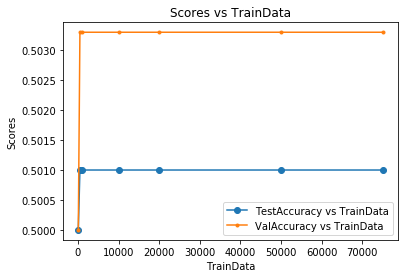

In [26]:
accuracyVisualization()

In [27]:
def mrrVisualization():
    ''' Plots the data points with the centroids
    '''
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(n_trainSamples,mrrScore,label='MRR vs TrainData',marker='x')
    plt.title("Scores vs TrainData")
    plt.legend()
    plt.xlabel("TrainData")
    plt.ylabel("Scores")
    fig.savefig("SVM_Tokens_Poly_Mrr.png")
    plt.show()

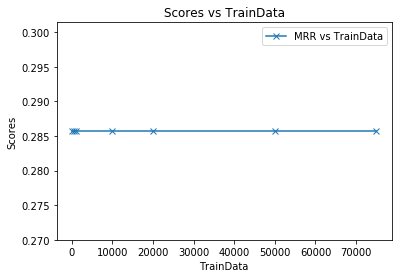

In [28]:
mrrVisualization()